##### Prior steps....

In [1]:
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
import seaborn as sns


sns.set()


In [2]:
path = untar_data(URLs.MNIST_SAMPLE)


In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()


In [4]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)


(6131, 6265)

In [5]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape


torch.Size([6131, 28, 28])

In [6]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape


(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### Dataset

Transform data from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor)

-1 is a special parameter to view that means “make this axis as big as necessary to fit all the data”

In [7]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

# 1 - is three and 0 - is seven
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape


(torch.Size([12396, 784]), torch.Size([12396, 1]))

Create a dataset

In [8]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y


(torch.Size([784]), tensor([1]))

The same way to create a valid dataset

In [9]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_3_tens) + [0] *
                 len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))


Init weights

In [10]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


In [11]:
weights = init_params((28 * 28, 1))


w * x -- is not a flexible func. We need use the coeff b: w * x + b

Together, the weights and bias make up the parameters.

In [12]:
bias = init_params(1)


### First prediction

In [13]:
(train_x[0] * weights.T).sum() + bias


tensor([-6.2330], grad_fn=<AddBackward0>)

In [14]:
def linear1(xb):
    return xb @ weights + bias


In [15]:
preds = linear1(train_x)
preds


tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

Check our accuracy

In [16]:
corrects = (preds > 0.0).float() == train_y
corrects


tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [17]:
corrects.float().mean().item()  # Item is not necessary (tensor([0.53...]))


0.5379961133003235

How change accuracy when we change weights

In [18]:
with torch.no_grad():
    weights[0] *= 1.0001

preds = linear1(train_x)
((preds > 0.0).float() == train_y).float().mean().item()


0.5379961133003235

```
weights[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()
0.4912068545818329
```

### First loss func

In [19]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


where func is the same that 

```torch.where(a,b,c)```

```[b[i] if a[i] else c[i] for i in range(len(a))]```


except it works on tensors, at C/CUDA speed.

In [20]:
trgts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])
torch.where(trgts == 1, 1 - prds, prds)


tensor([0.1000, 0.4000, 0.8000])

Let's try to use it

In [21]:
mnist_loss(prds, trgts)


tensor(0.4333)

In [22]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)


tensor(0.2333)

### Sigmoid

We need to have accur between 0 and 1...

PyTorch defines an accelerated sigmoid for us

In [23]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


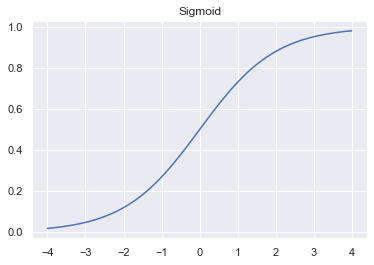

In [24]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)


### Implement the sigmoid func into our loss func
Now we can be confident our loss function will work, even if the predictions are not
between 0 and 1

In [25]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


The key difference is that the metric is to drive human understanding and the loss is
to drive automated learning.